# DATASET EXPLORATION AND PREPARATION

In [14]:
import pandas as pd

file_path = 'arxiv-metadata-oai-snapshot.json'
data = pd.read_json(file_path, lines= True, nrows=15000)

data.head()

,id,submitter,authors,title,comments,journal-ref,doi,report-no,categories,license,abstract,versions,update_date,authors_parsed
0,704.0001,Pavel Nadolsky,"C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-...",Calculation of prompt diphoton production cros...,"37 pages, 15 figures; published version","Phys.Rev.D76:013009,2007",10.1103/PhysRevD.76.013009,ANL-HEP-PR-07-12,hep-ph,None,A fully differential calculation in perturba...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2008-11-26,"[[Balázs, C., ], [Berger, E. L., ], [Nadolsky,..."
1,704.0002,Louis Theran,Ileana Streinu and Louis Theran,Sparsity-certifying Graph Decompositions,To appear in Graphs and Combinatorics,None,None,None,math.CO cs.CG,http://arxiv.org/licenses/nonexclusive-distrib...,"We describe a new algorithm, the $(k,\ell)$-...","[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2008-12-13,"[[Streinu, Ileana, ], [Theran, Louis, ]]"
2,704.0003,Hongjun Pan,Hongjun Pan,The evolution of the Earth-Moon system based o...,"23 pages, 3 figures",None,None,None,physics.gen-ph,None,The evolution of Earth-Moon system is descri...,"[{'version': 'v1', 'created': 'Sun, 1 Apr 2007...",2008-01-13,"[[Pan, Hongjun, ]]"
3,704.0004,David Callan,David Callan,A determinant of Stirling cycle numbers counts...,11 pages,None,None,None,math.CO,None,We show that a determinant of Stirling cycle...,"[{'version': 'v1', 'created': 'Sat, 31 Mar 200...",2007-05-23,"[[Callan, David, ]]"
4,704.0005,Alberto Torchinsky,Wael Abu-Shammala and Alberto Torchinsky,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,None,"Illinois J. Math. 52 (2008) no.2, 681-689",None,None,math.CA math.FA,None,In this paper we show how to compute the $\L...,"[{'version': 'v1', 'created': 'Mon, 2 Apr 2007...",2013-10-15,"[[Abu-Shammala, Wael, ], [Torchinsky, Alberto, ]]"


# Data Cleaning

In [19]:

if 'publication_date' in data.columns:
    data['publication_date'] = pd.to_datetime(data['publication_date'], errors='coerce')

def convert_lists_to_strings(df, columns):
    for col in columns:
        if col in df.columns:
            df[col] = df[col].apply(lambda x: ' '.join([str(elem) for elem in x]) if isinstance(x, list) else str(x))
    return df

list_columns = ['authors', 'comments', 'categories', 'versions', 'authors-parsed']

data = convert_lists_to_strings(data, list_columns)

data.isnull().sum()

data = data.dropna()

try:
    data = data.drop_duplicates(subset=[col for col in data.columns if not isinstance(data[col].iloc[0], list)])
except Exception as e:
    print("Error occurred during duplication removal process:", e)

data.isnull().sum()

try:
    unhashable_columns = [col for col in data.columns if not isinstance(data[col].iloc[0], list)]
    duplicated_rows = data.duplicated(subset=unhashable_columns)
    num_duplicates = duplicated_rows.sum()
    print("Duplicated rows after cleaning:", num_duplicates)
except Exception as e:
    print("Error occurred during duplication check:", e)



Duplicated rows after cleaning: 0


# Extract Keywords and Topics Using NLP

In [22]:
import nltk

nltk.download('punkt')
nltk.download('stopwords')

def extract_keywords(text):
    tokens = nltk.word_tokenize(text)
    words = [word for word in tokens if word.isalpha()]
    stopwords = nltk.corpus.stopwords.words('english')
    keywords = [word for word in words if word.lower() not in stopwords]
    return keywords

data['keywords'] = data['title'].apply(lambda x: extract_keywords(x)) + data['abstract'].apply(lambda x: extract_keywords(x))

data['keywords'] = data['keywords'].apply(lambda x: ' '.join(x) if isinstance(x, list) else x)


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Visualization

Visualization 1: Word Cloud for Popular Topics

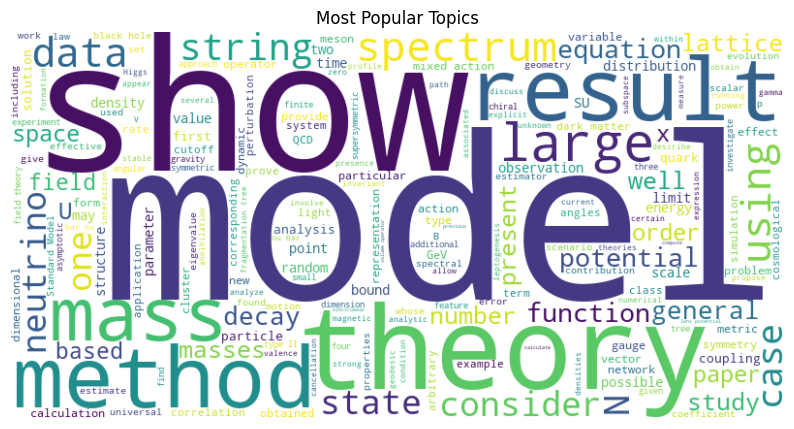

In [24]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

all_keywords = ' '.join(data['keywords'])
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_keywords)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Popular Topics')
plt.show()


Visualization 2: Temporal Evolution Line Graph

datetime64[ns]


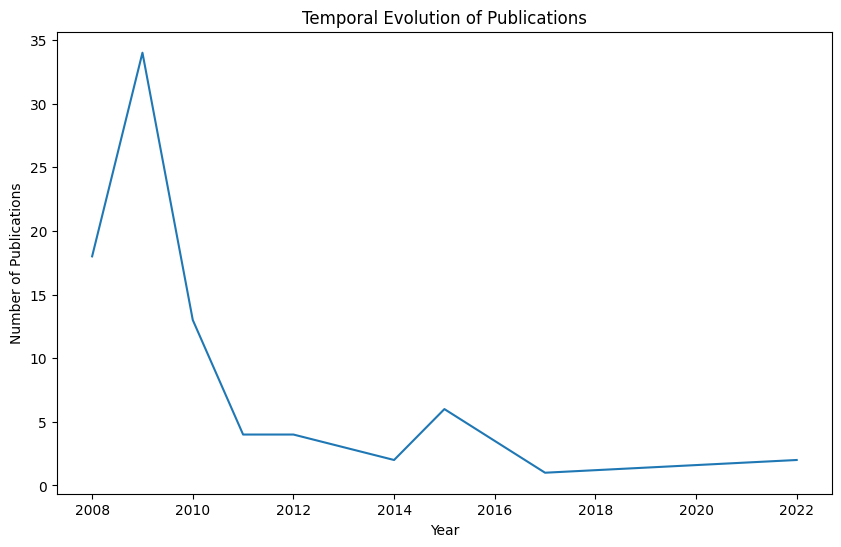

In [25]:
import matplotlib.pyplot as plt

data['publication_date'] = pd.to_datetime(data['update_date'], errors='coerce')

print(data['publication_date'].dtype)

temporal_data = data.groupby(data['publication_date'].dt.year).size()

plt.figure(figsize=(10, 6))
temporal_data.plot(kind='line')
plt.title('Temporal Evolution of Publications')
plt.xlabel('Year')
plt.ylabel('Number of Publications')
plt.show()


Visualization 3: Geographic Distribution Map

In [33]:
import pandas as pd
import geopandas as gpd
import plotly.express as px
import random

data = pd.DataFrame({
    'id': [1, 2, 3, 4, 5, 6, 7],
    'authors': ["Alexander", "Boris", "Charlie", "Debashish", "Eve", "Frank", "Grace"],
    'country': ["USA", "Canada", "Brazil", "Denmark", "India", "Netherlands", "Africa"] 
})

country_counts = data['country'].value_counts().reset_index()
country_counts.columns = ['country', 'count']

world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

merged = world.set_index('name').join(country_counts.set_index('country'))

merged.reset_index(inplace=True)

fig = px.choropleth(merged, 
                    locations='name',
                    locationmode='country names',
                    color='count',
                    hover_name='name', 
                    color_continuous_scale=px.colors.sequential.Plasma,
                    title='Geographic Distribution of Authors')
fig.show()


C:\Users\admin\AppData\Local\Temp\ipykernel_5112\1546812139.py:15: FutureWarning:

The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.



# Discussion on Responsible Use of Technology in Graphics and Visual Computing
1. Ethical Implications of Identified Trends
    In the context of graphics and visual computing, several emerging trends have significant ethical implications:

* Enviromental Impact

    * Concerns about environmental sustainability stem from the high power consumption and e-waste produced by graphics and visual computing technology.

    * We have a responsibility to maintain the environment and health so that future generations can be happy and healthy.

* Transparency and Accountability

    * Opacity occurs when algorithms operate in an unclear manner, causing individuals to mistrust and be unable to explain why they perform poorly.

    * People should be able to understand how their difficulties influence them, but this can only happen if the programs are not clear.

* Education and Training

    * Awareness is required to ensure proper use of technology. This includes training both experts and the general people so that they can utilize it wisely and ethically.

    * Keeping ethical values in mind might help you avoid misusing graphic design and visual computing technology.

2.Potential Impact of Emerging Technologies on Society
Emerging visual computing technologies can have both positive and negative impacts on society:

* Positive Impacts

    * Enhanced Learning: AR and VR provide immersive learning experiences, making complex subjects easier to understand and retain.

    * Enhanced Design and Visualization: Visual computing technologies allow architects, designers, and engineers to build and visualize complicated designs in 3D, resulting in more efficient workflows, better decision-making, and novel designs.

* Negative Impacts

    * Cybersecurity concerns: Immersive technologies may pose new cybersecurity concerns, such as illegal access to sensitive data, hacking of virtual environments, and malware spreading over virtual platforms.

    * Privacy risks: As previously said, processing and presenting sensitive data, particularly geographic information, presents privacy risks. Unauthorized access or inappropriate use of this data can result in significant privacy violations.

3. Guidelines for the Responsible Development and Use of Visual Computing Technologies
To ensure the responsible development and use of visual computing technologies, the following guidelines can be proposed:

    * Privacy by Design: Include privacy features in the design of visual computing technologies from the beginning. Implement data anonymization techniques, limit data collection and retention, and give people clear information about how their data will be used.

    * Continuous Evaluation and Improvement: Based on user, expert, and stakeholder feedback, review and enhance visual computing technologies on an ongoing basis. Monitor their influence on privacy, security, justice, and social well-being, then iteratively improve their design and implementation to accommodate new difficulties and concerns.

    * Transparency and accountability: Encourage transparency and accountability in the design and implementation of visual computing technologies. Disclose information about the algorithms, data sources, and decision-making processes employed in these systems, and develop methods for accountability and redress in the event of errors or misuse.

    * User Education and Awareness: Inform users on the possibilities, limitations, and risks of visual computing technology. Provide clear and accessible information regarding privacy practices, security measures, and ethical issues so that users may make educated decisions about how to utilize these technologies.